In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
from matplotlib import pyplot as plt
import numpy as np

In [3]:
"""
cfg.py 

Simulation configuration for ...
This file has sim configs as well as specification for parameterized values in netParams.py 

Contributors: conrad.bittencourt@gmail.com, fernandodasilvaborges@gmail.com
"""

from netpyne import specs

cfg = specs.SimConfig()     

#------------------------------------------------------------------------------
#
# SIMULATION CONFIGURATION
#
#------------------------------------------------------------------------------

cfg.coreneuron = False
rootFolder = os.getcwd()

#------------------------------------------------------------------------------
# Run parameters
#------------------------------------------------------------------------------

cfg.duration = 3000.0 ## Duration of the sim, in ms  
cfg.dt = 0.01
cfg.hParams = {'celsius': 36, 'v_init': -84}  

cfg.allpops = []
cfg.allcells = ['sPY','sPY_IL','sPY_IT','sPY_IL_IT']

for cell in cfg.allcells:
    cfg.allpops.append(f'pop_{cell}')

#------------------------------------------------------------------------------
# Current inputs 
#------------------------------------------------------------------------------
cfg.addIClamp = 1

delaystim = 500
durationstim = 2000

cfg.IClamp0 =   {'pop': cfg.allpops[0], 'sec': 'soma', 'loc': 0.5, 'start': delaystim, 'dur': durationstim, 'amp': 0.25}  
cfg.IClamp1 =   {'pop': cfg.allpops[1], 'sec': 'soma', 'loc': 0.5, 'start': delaystim, 'dur': durationstim, 'amp': 0.25}   
cfg.IClamp2 =   {'pop': cfg.allpops[2], 'sec': 'soma', 'loc': 0.5, 'start': delaystim, 'dur': durationstim, 'amp': 0.25}   
cfg.IClamp3 =   {'pop': cfg.allpops[3], 'sec': 'soma', 'loc': 0.5, 'start': delaystim, 'dur': durationstim, 'amp': 0.25}     

#------------------------------------------------------------------------------
# Record Data 
#------------------------------------------------------------------------------

cfg.recordCells = cfg.allpops  # which cells to record from
cfg.recordTraces = {'V_soma': {'sec':'soma_0', 'loc':0.5, 'var':'v'}}  ## Dict with traces to record
cfg.recordStim = True
cfg.recordTime = True
cfg.recordStep = cfg.dt         

cfg.simLabel = 'v0_batch0'
cfg.saveFolder = cfg.simLabel
cfg.savePickle = False         	## Save pkl file
cfg.saveJson = False           	## Save json file

In [4]:

netParams = specs.NetParams()   # object of class NetParams to store the network parameters

#------------------------------------------------------------------------------
# Cell parameters
#------------------------------------------------------------------------------
for cellName in cfg.allcells:
    cellRule = netParams.importCellParams(label=cellName + '_rule', somaAtOrigin=False,
        conds={'cellType': cellName, 'cellModel': 'HH_simple'},
        fileName='cellwrapper_Pospischil2008.py',
        cellName='loadCell',
        cellArgs={'template': cellName},
        cellInstance = True,
        importSynMechs=True
        )

    # observation:
    print(netParams.cellParams[cellName + '_rule']['secs']['soma_0'])

#------------------------------------------------------------------------------
# Population parameters
#------------------------------------------------------------------------------

# for ith-pop create pop with ith-cell of allcells 

for i, pop in enumerate(cfg.allpops):
    netParams.popParams[pop] = {
        'cellType': cfg.allcells[i],
        'cellModel': 'HH_simple',
        'numCells': 1
    }

#------------------------------------------------------------------------------
# Current inputs (IClamp)
#------------------------------------------------------------------------------
if cfg.addIClamp:
     for key in [k for k in dir(cfg) if k.startswith('IClamp')]:
        params = getattr(cfg, key, None)
        [pop,sec,loc,start,dur,amp] = [params[s] for s in ['pop','sec','loc','start','dur','amp']]

        #cfg.analysis['plotTraces']['include'].append((pop,0))  # record that pop
        # add stim source
        netParams.stimSourceParams[key] = {'type': 'IClamp', 'delay': start, 'dur': dur, 'amp': amp}
        # connect stim source to target
        netParams.stimTargetParams[key+'_'+pop] =  {
            'source': key, 
            'conds': {'pop': pop},
            'sec': f'{sec}_0', # target 'soma_0'
            'loc': loc}

Loading cell sPY
Creating a generic sPY cell from Pospischil2008 template
{geom: {L: 96.0, nseg: 1, diam: 96.0, Ra: 100.0, cm: 1.0}, topol: {}, mechs: {hh2: {gnabar: 0.05, gkbar: 0.005, vtraub: -55.0}, im: {gkbar: 3e-05}, pas: {g: 1e-05, e: -85.0}}, ions: {k: {e: -100.0, i: 54.4, o: 2.5}, na: {e: 50.0, i: 10.0, o: 140.0}}}
Loading cell sPY_IL
Creating a generic sPY_IL cell from Pospischil2008 template
{geom: {L: 96.0, nseg: 1, diam: 96.0, Ra: 100.0, cm: 1.0}, topol: {}, mechs: {cad: {depth: 1.0, taur: 5.0, cainf: 0.00024, kt: 0.0, kd: 0.0}, hh2: {gnabar: 0.05, gkbar: 0.005, vtraub: -55.0}, ical: {gcabar: 0.00022}, im: {gkbar: 3e-05}, pas: {g: 1e-05, e: -85.0}}, ions: {ca: {e: 120.0, i: 0.00024, o: 2.0}, k: {e: -100.0, i: 54.4, o: 2.5}, na: {e: 50.0, i: 10.0, o: 140.0}}}
Loading cell sPY_IT
Creating a generic sPY_IT cell from Pospischil2008 template
{geom: {L: 96.0, nseg: 1, diam: 96.0, Ra: 100.0, cm: 1.0}, topol: {}, mechs: {cad: {depth: 1.0, taur: 5.0, cainf: 0.00024, kt: 0.0, kd: 0.0

In [5]:
from netpyne import sim

sim.initialize(
    simConfig = cfg, 	
    netParams = netParams)  				# create network object and set cfg and net params
sim.net.createPops()               			# instantiate network populations
sim.net.createCells()              			# instantiate network cells based on defined populations
sim.net.connectCells()            			# create connections between cells based on params
sim.net.addStims() 							# add network stimulation
sim.setupRecording()              			# setup variables to record for each cell (spikes, V traces, etc)
sim.runSim()                      			# run parallel Neuron simulation  
sim.gatherData()                  			# gather spiking data and cell info from each node
sim.saveData()                    			# save params, cell info and sim output to file (pickle,mat,txt,etc)#
sim.analysis.plotData()         			# plot spike raster etc


Start time:  2023-06-19 22:11:15.066774

Creating network of 4 cell populations on 1 hosts...
  Number of cells on node 0: 4 
  Done; cell creation time = 0.00 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
Adding stims...
  Number of stims on node 0: 4 
  Done; cell stims creation time = 0.00 s.
Recording 8 traces of 2 types on node 0

Running simulation using NEURON for 3000.0 ms...
  Done; run time = 1.12 s; real-time ratio: 2.69.

Gathering data...
  Done; gather time = 0.05 s.

Analyzing...
  Cells: 4
  Connections: 0 (0.00 per cell)
  Spikes: 150 (12.50 Hz)
  Simulated time: 3.0 s; 1 workers
  Run time: 1.12 s
  Done; plotting time = 0.00 s

Total time = 1.17 s


Plotting recorded cell traces ... trace


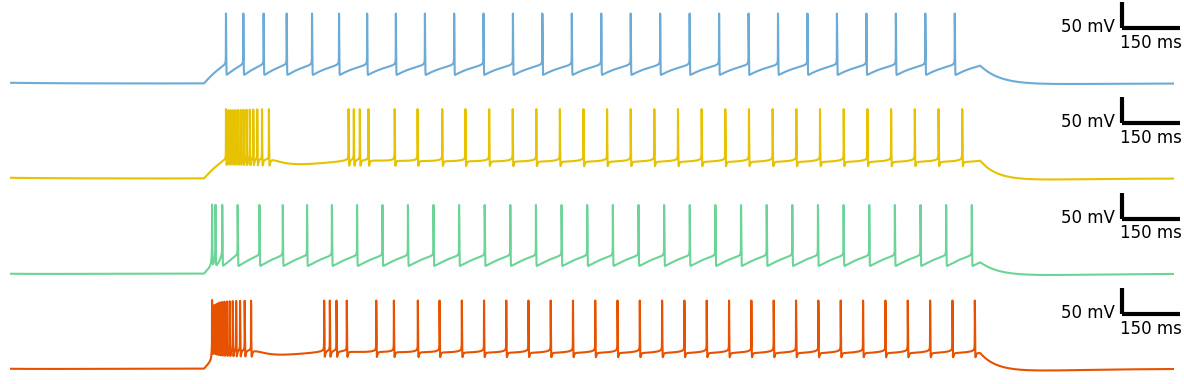

In [6]:
TR = sim.analysis.plotTraces(include=None,timeRange=[0,3000],oneFigPer='trace',rerun=False,title=None,subtitles=None,overlay=False,colors=None,ylim=None,axis=False,legend=True,scaleBarLoc=1,figSize=(12, 4),fontSize=12,saveData=None,saveFig=None,showFig=False,);

In [7]:
with open('../C/HH_N1.dat') as file:
    content = file.read()       

data = {}

for i in range(12):
    data[i] = []

for line in content.split('\n')[:-1]:
    t, V, m, h, n, p, q, r, cai, u, Eca, iCa = line.split()
    data[0].append(float(t))
    data[1].append(float(V))
    data[2].append(float(m))
    data[3].append(float(h))
    data[4].append(float(n))
    data[5].append(float(p))
    data[6].append(float(q))
    data[7].append(float(r))
    data[8].append(float(cai))
    data[9].append(float(u))
    data[10].append(float(Eca))
    data[11].append(float(iCa))

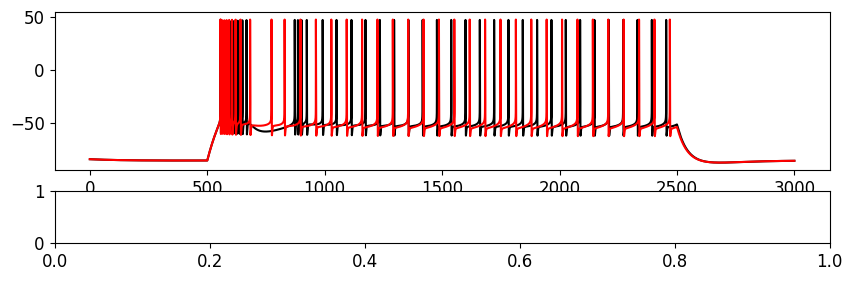

In [9]:
f, (ax0, ax1) = plt.subplots(2,1, figsize=(10,3), gridspec_kw = {'height_ratios':[3, 1]})

time = TR[1]['tracesData'][0]['t']
for cellNumber in range(1,2):
    voltage = TR[1]['tracesData'][cellNumber]['cell_'+str(cellNumber)+'_V_soma']
    ax0.plot(list(time)[1:],voltage, 'k')
    ax0.plot(data[0],data[1], 'r')
# ax1.plot([200,300,300,700,700,800],[0,0,0.75,0.75,0,0], 'gray')

# ax0.set_ylabel('Voltage (mV)')
# ax0.spines['right'].set_visible(False)
# ax0.spines['top'].set_visible(False)
# ax0.spines['bottom'].set_visible(False)
# ax0.get_xaxis().set_visible(False)


# # # ax1.plot([0,0],[0,0.75],'k')
# # ax1.text(225,0.35,'750pA',va='center')
# # ax1.set_ylabel('I (nA)')
# # ax1.set_xlabel('t (ms)')
# # ax1.spines['right'].set_visible(False)
# # ax1.spines['top'].set_visible(False)
# # ax1.spines['left'].set_visible(False)
# # ax1.get_yaxis().set_visible(False)
# # plt.tight_layout()